In [28]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score,f1_score,precision_score,recall_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import gaussian_kde
from utils import *

In [29]:
gene_exp_df = read_dataframe_from_pickle("data/processed_data/gene_exp_data.pkl")
label_df = read_dataframe_from_pickle("data/processed_data/label_data.pkl")
print("--" * 80)
print(f"Entries in Gene Expression Dataframe : {len(gene_exp_df)}")
print(f"Entries in Label Dataframe : {len(label_df)}")
labels_with_high_freq_df = remove_low_frequency_labels(label_df,threshold=150)
extracted_data,extracted_label = collect_relevant_data(gene_exp_df_bkp=gene_exp_df,label_df_bkp=labels_with_high_freq_df)
encoded_labels,label_encoder = encode_labels(extracted_label)
print("--" * 80)
print(f"Entries in Extracted Gene Expression Dataframe : {len(extracted_data)}")
print(f"Entries in Extracted Label Dataframe : {len(encoded_labels)}")

DataFrame successfully loaded from data/processed_data/gene_exp_data.pkl
DataFrame successfully loaded from data/processed_data/label_data.pkl
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Entries in Gene Expression Dataframe : 5268
Entries in Label Dataframe : 5268
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Entries in Extracted Gene Expression Dataframe : 4392
Entries in Extracted Label Dataframe : 4392


In [3]:
df = extracted_data.copy()

In [ ]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(extracted_data)
df_scaled = pd.DataFrame(X_scaled, columns=extracted_data.columns)
# Calculate variance of each feature
variances = df_scaled.var()

# Plot feature variance
fig = px.histogram(variances,
                   nbins=50,
                   labels={'value': 'Variance'},
                   title='Distribution of Feature Variance')

fig.update_layout(xaxis_title='Variance',
                  yaxis_title='Number of Features')
fig.show()


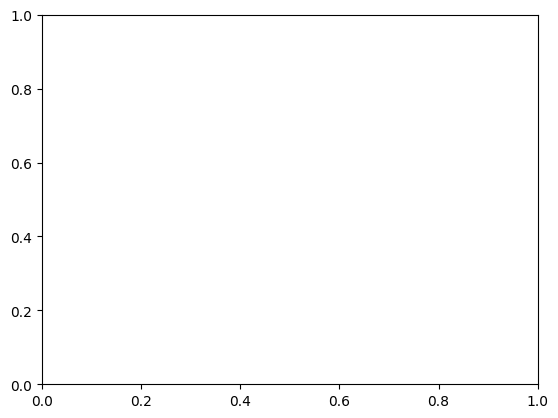

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go
import seaborn as sns

# Normalize the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(extracted_data)
df_scaled = pd.DataFrame(X_scaled, columns=extracted_data.columns)

# Calculate variance of each feature
variances = df_scaled.var()

# Filter for variances > 0
variances = variances[variances > 0]

# Use Seaborn to compute KDE
sns_data = sns.histplot(variances, kde=True, stat="count", bins=50)
x_kde = sns_data.lines[0].get_xdata()
y_kde = sns_data.lines[0].get_ydata()
sns_data.clear()

# Create pastel histogram
hist = go.Histogram(
    x=variances,
    nbinsx=50,
    name='Histogram',
    marker_color='rgba(102, 194, 165, 0.7)',  # Pastel green
    opacity=0.75
)

# KDE curve
kde_line = go.Scatter(
    x=x_kde,
    y=y_kde,
    mode='lines',
    name='KDE',
    line=dict(color='rgba(141, 160, 203, 1)', width=3)  # Pastel blue
)

# Combine and layout
fig = go.Figure(data=[hist, kde_line])

fig.update_layout(
    title='Distribution of Feature Variance (x > 0)',
    xaxis_title='Variance',
    yaxis_title='Number of Features',
    template='simple_white'
)

fig.show()


In [54]:
def compute_variance_inflation_threshold(X_scaled,vif_thresholds):
# Apply MinMax scaling
    vif_xtemp = {}
    X_temp = X_scaled.copy()
    iteration = 1

    while True:
        print(f"Iteration {iteration}")
        vif_df = pd.DataFrame()
        vif_df["Feature"] = X_temp.columns
        vif_df["VIF"] = [variance_inflation_factor(X_temp.values, i) for i in range(X_temp.shape[1])]
        
        max_vif = vif_df["VIF"].max()

        for thresh in vif_thresholds:
            if thresh not in vif_xtemp and max_vif <= thresh:
                vif_xtemp[thresh] = X_temp.copy()
                print(f"✅ Cached X_temp at threshold {thresh} with {X_temp.shape[1]} features")

        high_vif = vif_df[vif_df["VIF"] > vif_thresholds[0]]  # base threshold

        if high_vif.empty:
            break

        total_features = X_temp.shape[1]
        drop_k = max(1, total_features // 40)
        drop_count = min(drop_k, high_vif.shape[0])
        
        drop_features = high_vif.sort_values("VIF", ascending=False).head(drop_count)["Feature"].tolist()
        X_temp = X_temp.drop(columns=drop_features)

        # print(f"Max VIF: {max_vif:.2f} | Features left: {len(X_temp.columns)}")
        iteration += 1

    # Ensure all remaining thresholds are cached
    for thresh in vif_thresholds:
        if thresh not in vif_xtemp:
            vif_xtemp[thresh] = X_temp.copy()
    return vif_xtemp



In [55]:
results = []

In [56]:
# Apply MinMax scaling
X = extracted_data.copy()
y = encoded_labels
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

vif_thresholds = [15,20,25,30]
selection_thresholds = [0.014,0.016,0.018]
# vif_thresholds = [90]
# selection_thresholds = [0.022]
for selection_threshold in selection_thresholds:
    print("=="*40)
    var_thresh = VarianceThreshold(threshold=selection_threshold)
    X_var_filtered = var_thresh.fit_transform(X_scaled)
    kept_columns = X_scaled.columns[var_thresh.get_support()]
    X_var_selected = pd.DataFrame(X_var_filtered, columns=kept_columns)
    print(f"Step : Variance Based Selection | Selection Threshold : {selection_threshold}")
    print("**" * 40)
    print("Proceeding to VIF Step")
    vif_xtemp = compute_variance_inflation_threshold(X_scaled=X_var_selected,vif_thresholds=vif_thresholds) 
    del X_var_selected
    print("**" * 40)
    print("Proceeding to Model Training Step")
    for run in range(3):
        for vif_thresh, X_temp in vif_xtemp.items():
            # Step 3: Train/Test and Evaluate
            print(f"Step : Variance Inflation Threshold Based Selection | VIF Threshold : {vif_thresh} | Run {run+1}")
            X_train, X_test, y_train, y_test = train_test_split(X_temp, y, test_size=0.2, random_state=(run*10)+2)
            # print(f"Model Training :: X_train size : {len(X_train)} | y_train size : {len(y_train)}")
            # print(f"Model Training :: X_test size : {len(X_test)} | y_test size : {len(y_test)}")
            model = SVC(kernel='rbf', C=3, class_weight='balanced', gamma='scale',random_state=(run*10)+3)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_pred_train = model.predict(X_train)        

            acc = model.score(X_test, y_test)
            f1_macro = f1_score(y_test, y_pred, average='macro')
            f1_weighted = f1_score(y_test, y_pred, average='weighted')
            balanced_accuracy = balanced_accuracy_score(y_test,y_pred)
            # Output results
            results.append({
                    "experiment_number":run+1,
                    "Selection Threshold": selection_threshold,
                    "NumFeatures": len(X_train.columns),
                    "VIFThreshold": vif_thresh,
                    'train_f1_macro':f1_score(y_train, y_pred_train, average='macro'),
                    'test_f1_macro':f1_score(y_test, y_pred, average='macro'),
                    'test_balanced_accuracy': balanced_accuracy_score(y_test, y_pred),
                    'test_f1_weighted': f1_score(y_test, y_pred, average='weighted'),
                    "precision_weighted" : precision_score(y_test, y_pred, average='weighted'),
                    "recall_weighted" : recall_score(y_test, y_pred, average='weighted'),
                })
            print("Completed Successfully\n\n")


Step : Variance Based Selection | Selection Threshold : 0.014
********************************************************************************
Proceeding to VIF Step
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
✅ Cached X_temp at threshold 30 with 408 features
Iteration 8
Iteration 9
Iteration 10
Iteration 11
✅ Cached X_temp at threshold 25 with 371 features
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
✅ Cached X_temp at threshold 20 with 329 features
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
✅ Cached X_temp at threshold 15 with 269 features
********************************************************************************
Proceeding to Model Training Step
Step : Variance Inflation Threshold Based Selection | VIF Threshold : 30 | Run 1
Completed Successfully


Step : Variance Inflation Threshold Based Selection | VIF Threshold : 25 | Run 1
Completed Succes

In [58]:
df = pd.DataFrame(results)
df.to_csv("results/VIF_SELECTION_RESULTS_MULTI_RUN.csv",index=False)

In [59]:
df = pd.read_csv("results/VIF_SELECTION_RESULTS_MULTI_RUN.csv")
df.sort_values(["experiment_number","Selection Threshold","VIFThreshold"],inplace=True)
res = df.groupby(["Selection Threshold","VIFThreshold"])[["test_f1_macro","NumFeatures"]].mean().reset_index()
res["test_f1_macro"] = res["test_f1_macro"]*100
res["NumFeatures"] = res["NumFeatures"].astype(int)
res = res[(res["VIFThreshold"] != 10) & (res["Selection Threshold"] != 0.02)]
fig = px.line(
    res,
    x="VIFThreshold",
    y="test_f1_macro",
    color="Selection Threshold",
    text="NumFeatures",
    title="SVM Accuracy vs VIF Threshold",
    markers=True
)
fig.update_traces(textposition="top center")
fig.show()

In [ ]:
df = pd.read_pickle("results/VIF_Reports.pkl")

In [ ]:
import re

def extract_weighted_avg(report_text):
    # Find the 'weighted avg' line
    lines = report_text.strip().split('\n')
    for line in lines:
        if 'weighted avg' in line:
            parts = re.split(r'\s+', line.strip())
            precision = float(parts[2])
            recall = float(parts[3])
            return precision, recall
    # If not found, return NaNs
    return np.nan, np.nan

In [ ]:
df[['weighted_avg_precision', 'weighted_avg_recall']] = df['classification report'].apply(
    lambda x: pd.Series(extract_weighted_avg(x))
)

In [ ]:
df.columns

Index(['Selection Threshold', 'VIFThreshold', 'classification report',
       'confusion matrix', 'cohen kappa', 'matthews_corrcoef', 'f1_macro',
       'f1_weighted', 'balanced_accuracy', 'weighted_avg_precision',
       'weighted_avg_recall'],
      dtype='object')

In [ ]:
record = df.drop(columns=['classification report',
       'confusion matrix', 'cohen kappa', 'matthews_corrcoef'])

In [ ]:
record.to_csv("results/VIF_Detailed_Results_mutil_run.csv")